### Overview

Suppose you are working with a rancher in Central Texas. The rancher is building a rainwater harvesting/recapture system, and he/she wants to ensure that the system will not run out of water. 

The rancher thinks that a 25-thousand-gallon tank and a 3-thousand-square-foot roof capture area will be sufficient. The rancher asks you to check. The rancher has questions, "What are the chances that the volume in the storage tank will reach zero? Will a larger tank or roof be needed?"

In [7]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import datetime

In [8]:
#Upload input rainfall data
data_orig = pd.read_csv('monthly-rainfall-data.csv')
data_orig.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,2000,1.09,1.27,0.42,1.70,1.42,4.52,0.92,0.00,1.90,7.26,0.00,1.10
1,2001,3.94,1.01,2.78,4.09,4.63,0.83,0.00,6.24,3.87,3.55,3.94,2.67
2,2002,0.39,0.39,1.54,2.43,1.29,0.00,7.79,1.08,6.87,7.11,2.38,3.74
3,2003,4.10,2.65,2.36,0.11,0.16,4.15,8.41,0.95,7.94,2.18,0.27,0.14
4,2004,2.65,1.77,4.31,8.58,2.61,10.28,2.57,4.72,1.44,4.94,7.50,0.07


In [9]:
data = pd.melt(data_orig,
               id_vars='Year',
               value_vars = ['Jan','Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
               value_name='Rainfall')
data['Date'] = data['Year'].astype(str) + '-' + data['variable'].astype(str)
data.head()

,Year,variable,Rainfall,Date
0,2000,Jan,1.09,2000-Jan
1,2001,Jan,3.94,2001-Jan
2,2002,Jan,0.39,2002-Jan
3,2003,Jan,4.10,2003-Jan
4,2004,Jan,2.65,2004-Jan


In [10]:
#Clean data to use for visualization
monthly_rain=data.groupby(['variable']).mean()
monthly_rain=monthly_rain.drop('Year',axis=1)
monthly_rain['Prob']=(monthly_rain['Rainfall']/sum(monthly_rain['Rainfall']))
mean_rain=monthly_rain['Rainfall'].mean()
std_rain=monthly_rain['Rainfall'].std()
print(mean_rain)
print(std_rain)

2.3561111111111113
0.8732567290406728


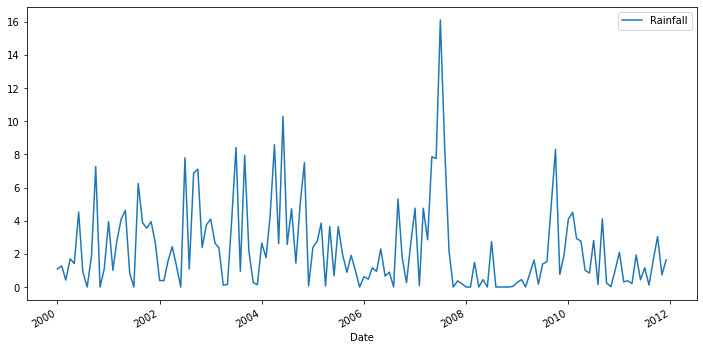

In [11]:
data['Date'] = pd.to_datetime(data['Date']) # convert date column to DateTime
ax = data.plot(x='Date', y='Rainfall', figsize=(12,6))

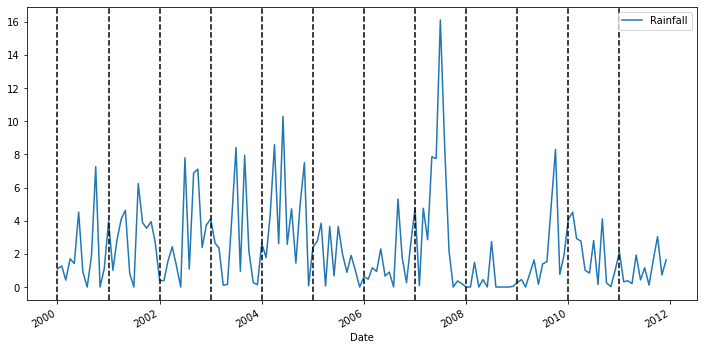

In [12]:
ax = data.plot(x='Date', y='Rainfall', figsize=(12,6))
xcoords = ['2000-01-01', '2001-01-01','2002-01-01', '2003-01-01', '2004-01-01', '2005-01-01',
          '2006-01-01','2007-01-01','2008-01-01','2009-01-01','2010-01-01','2011-01-01']
for xc in xcoords:
    ax.axvline(x=xc, color='black', linestyle='--')

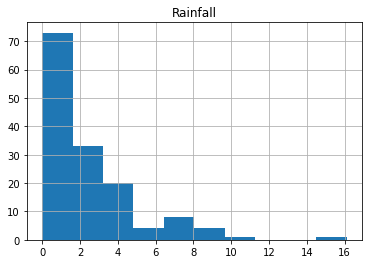

In [13]:
histogram = data.hist(column='Rainfall')

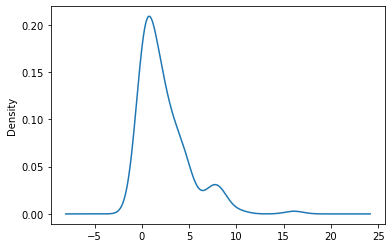

In [14]:
cdf = data['Rainfall'].plot.density()

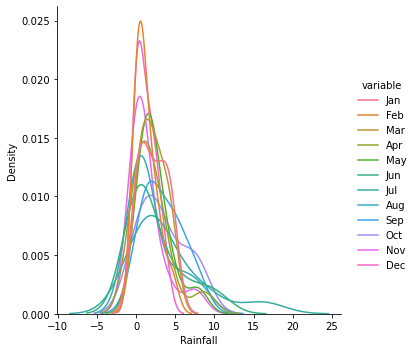

In [15]:
sns.displot(data=data, x="Rainfall", hue="variable", kind="kde");

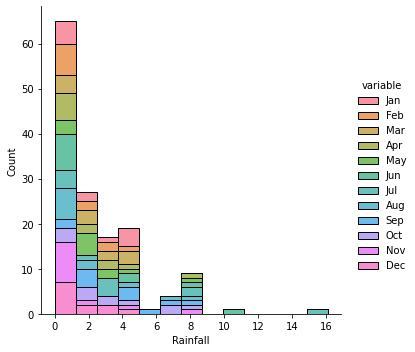

In [16]:
sns.displot(data=data, x="Rainfall", hue="variable", multiple='stack');

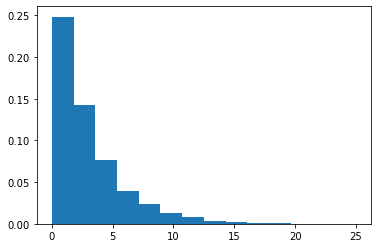

In [17]:
#Exponential Decay - Random Number

expo = np.random.exponential(3, 10000)
  
count, bins, ignored = plt.hist(expo, 14, density = True)
plt.show()

Based on the distribution of the data, we will take the approach of bootstrapping. This is to done to randomly sample the data and account for variance throughout the seasons so the farmer can have an idea how the tank will perform throughout the year. Ideally this will help distribute the higher and lower ends of the rainfall throughout the simulations.

### Program simulation description and scenarios

We will be using Monte Carlo simulation and bootstrapping for sampling to determine the performance of the farmer's water tank. To accomplish this, the tank is assumed to be a cylindrical shape with a circular cross section with the area of 3000 square feet. In order to maintain consistency in units, tank volume measurements are converted from gallons to inches. In the simulations and results, the amount of water in the tank will be represented by the height of the water in the tank, in inches. Below are two diagrams that show how each starting parameter was determined and the tank flow diagram:

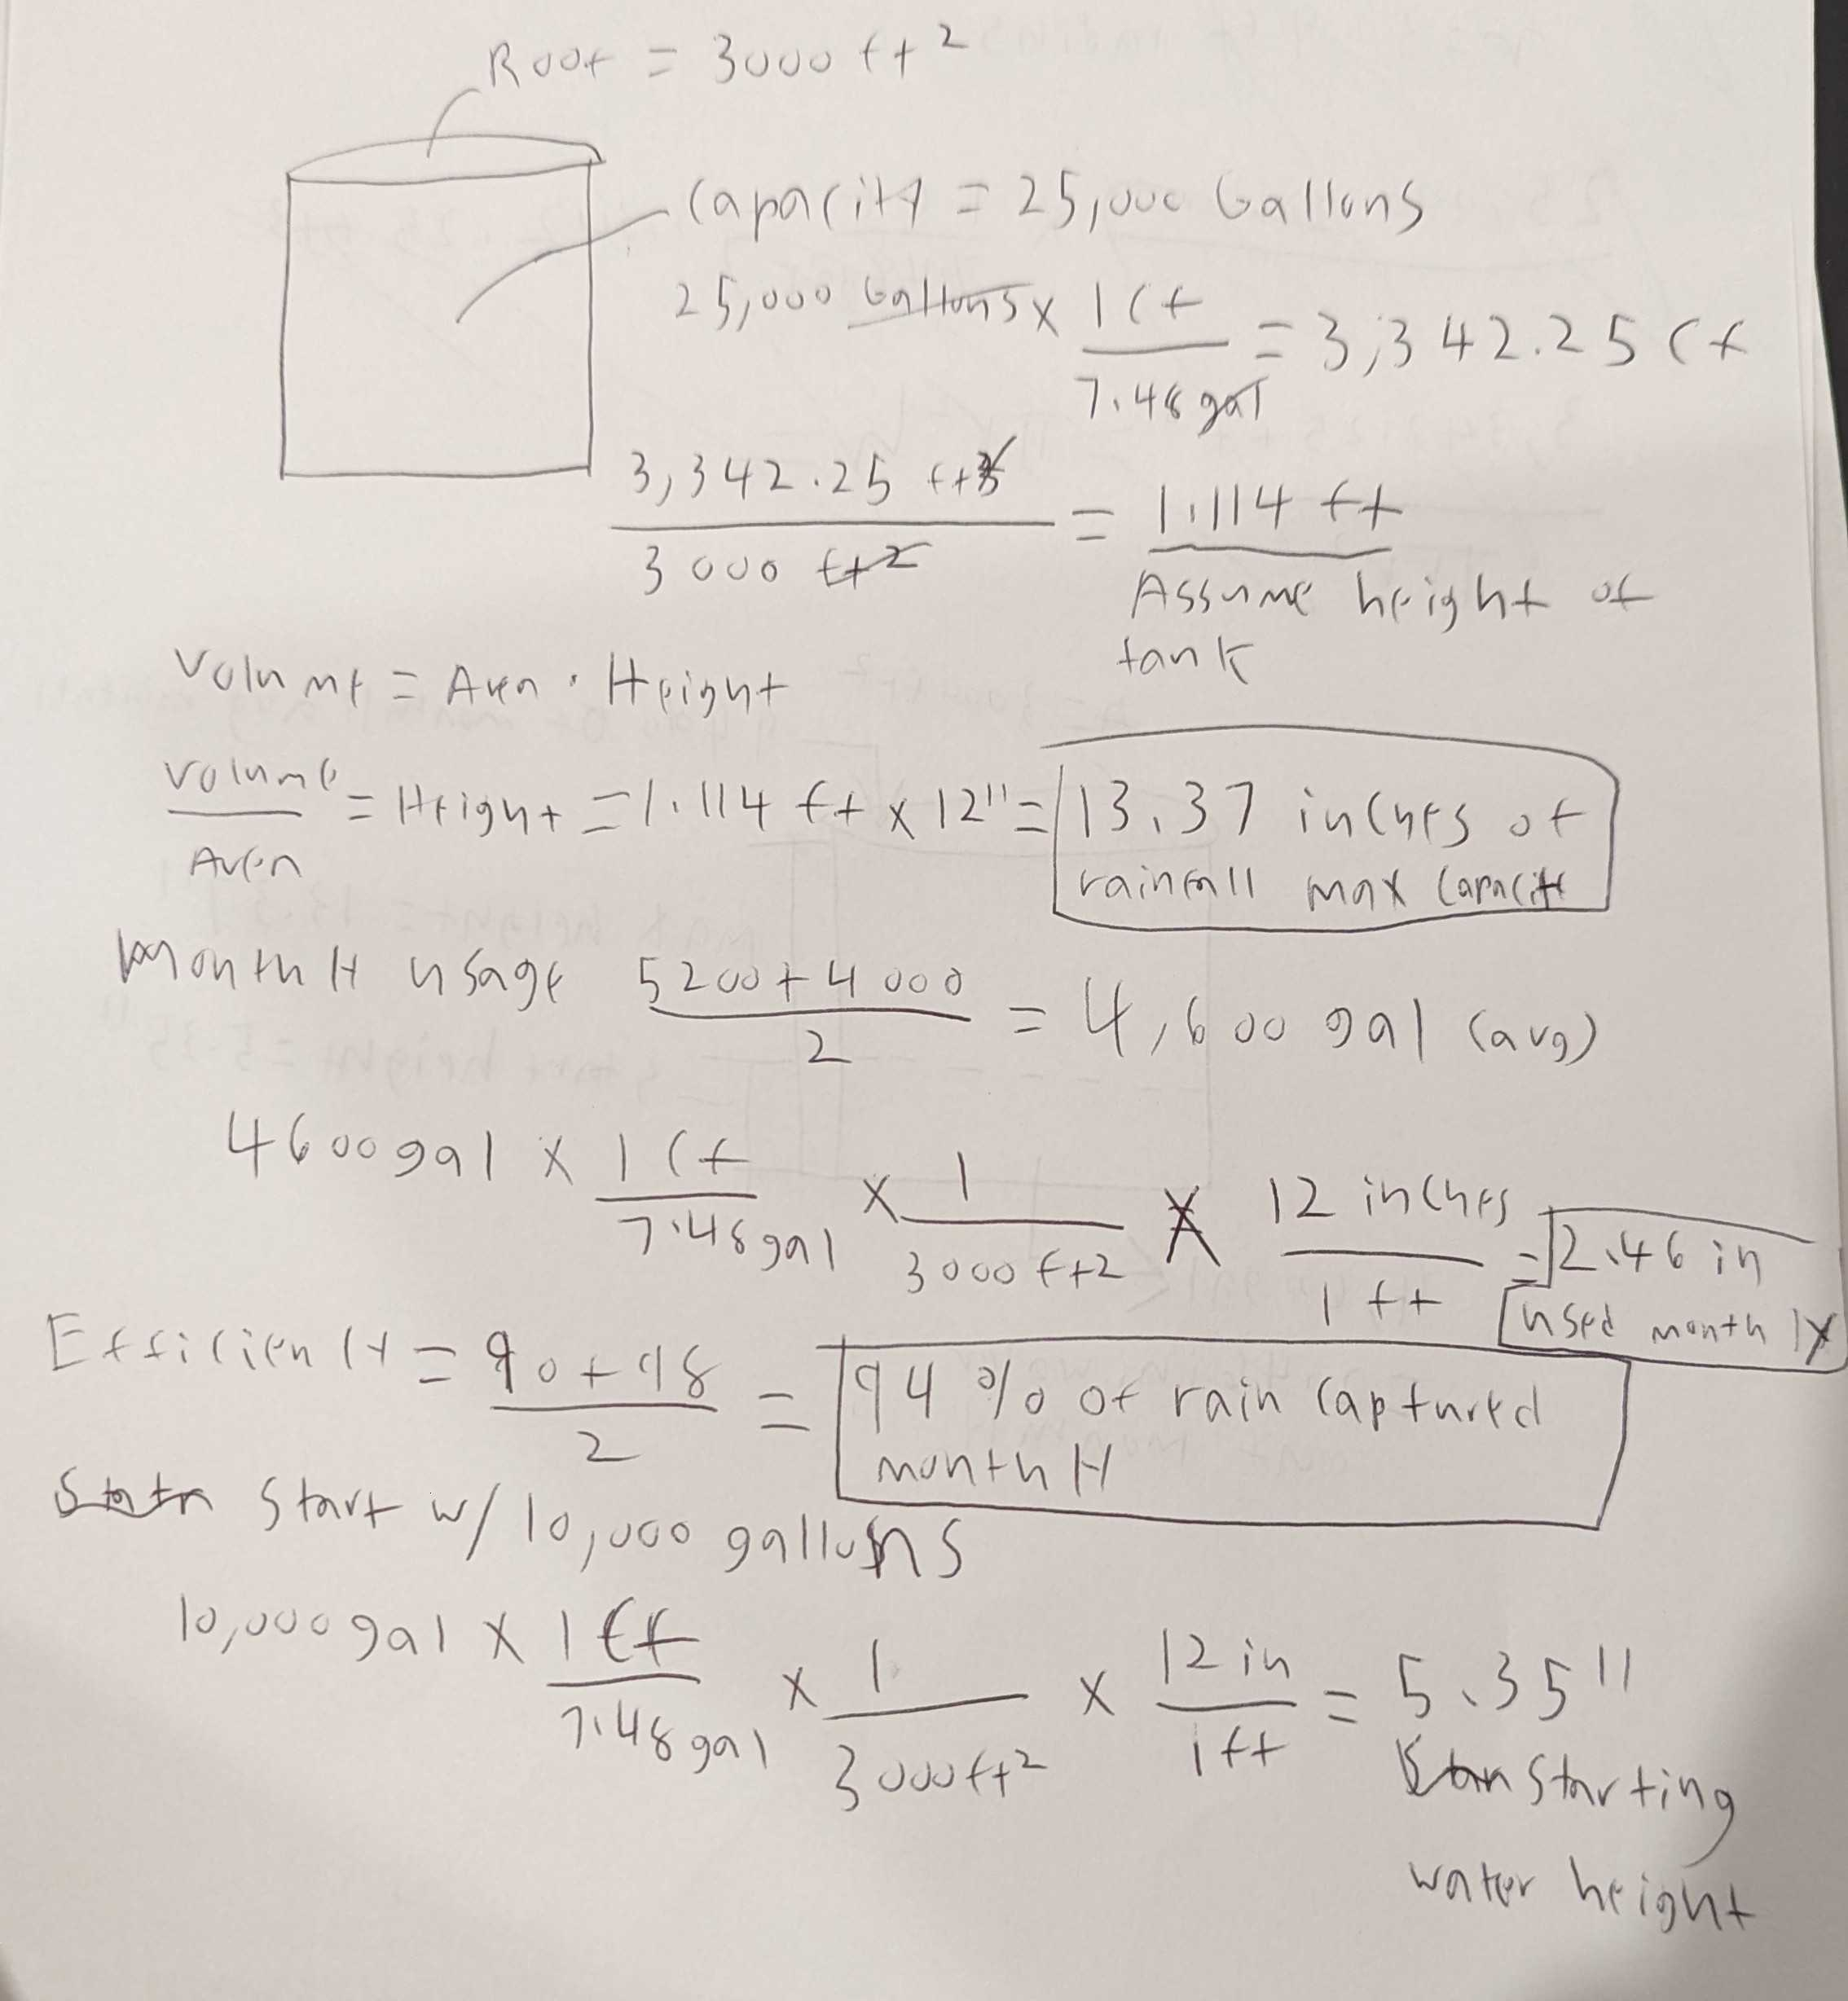





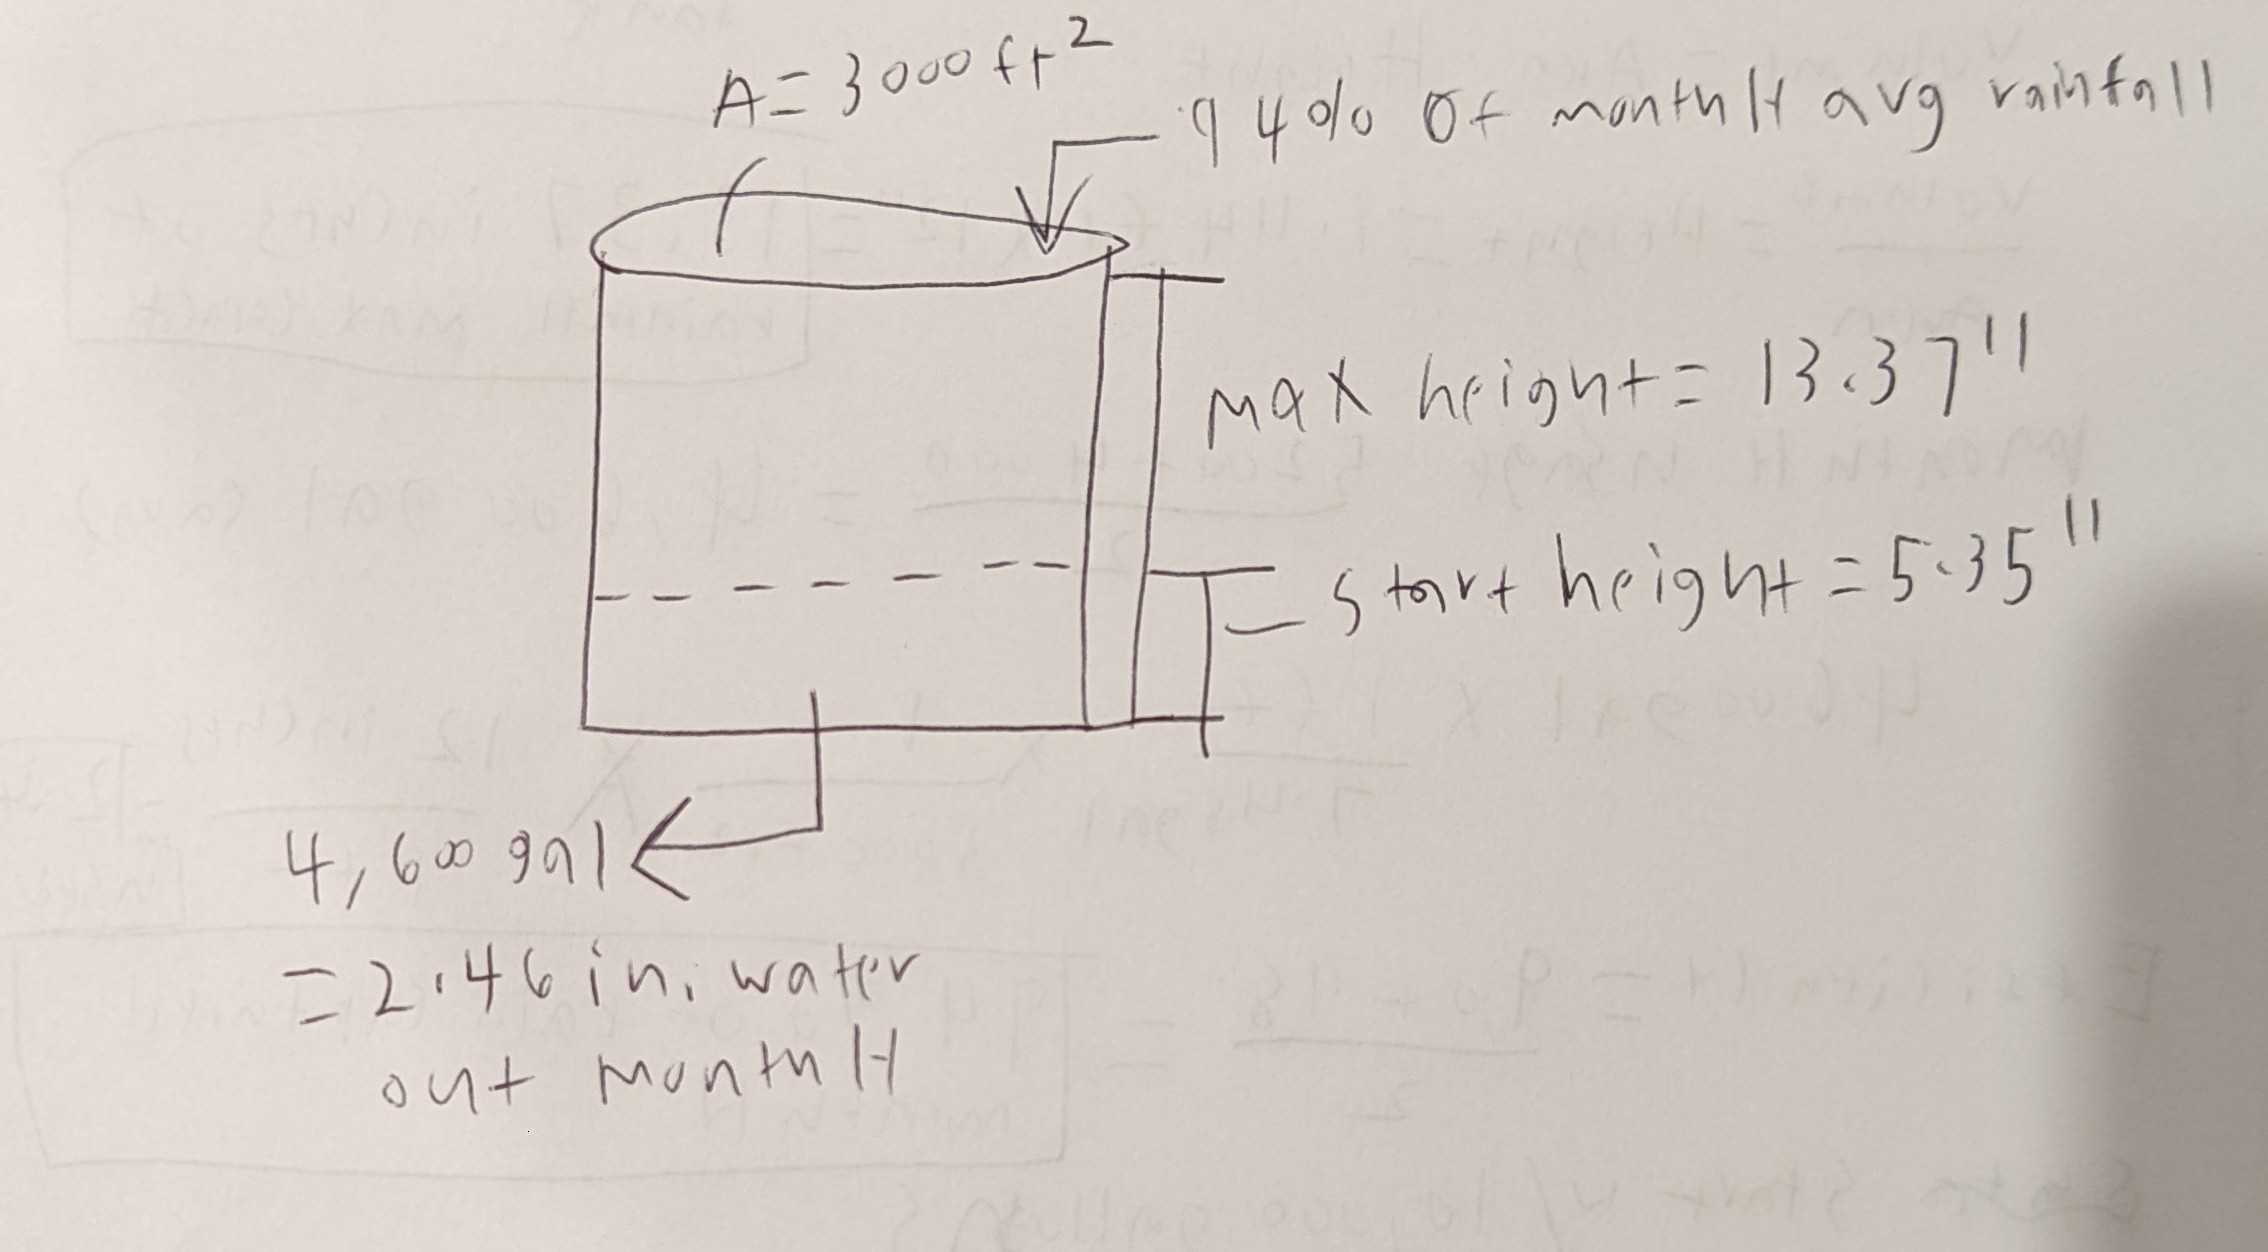

# ***INSERT MONTE CARLO FLOW CHART DIAGRAM HERE***

We created the function below to calcluate the depth of the water in the tank every month for each simulation. The function takes the existing tank depth and monthly rainfall samples as inputs and returns the depth of water in the tank after the monthly rainfall flows in and the discharge flows out. The function also keeps track of how many months the tank is completely empty and when it is at full capacity.

This program will be used to answer the rancher's questions by estimating the effects of random rainfall based on actual data over the course of 30 years and 1000 simulations. This will allow the farmer to see how often the tank empties and overflows based on the current design. With this program, we hope to answer the following questions:

- Is the water tank big enough?

- What should be improved to keep the tank from emptying?

- How often does the tank overflow?

### Base Scenario: Minimum amount of rainfall captured and maximum amount of monthly discharge.

In [50]:
#Monthly tank depth function, tank depth should never be negative OR above max_height
# max_height= 13.37 #maximum height of water in tank; anything above this will overflow out of tank
# pct_cap=0.90 #minimum amount of monthly rainfall captured (avg between 90-98%)
# monthly_dis=2.78 #maximum height of water discharged from tank per month (avg between 4000-5200 gallons [2.13-2.78 inches])

def TankRange(existing_tank_depth,monthly_rainfall):
    tank_depth=existing_tank_depth+(monthly_rainfall*pct_cap)-monthly_dis
    if tank_depth < 0:
        tank_depth = 0
        global dry_count
        global y
        dry_count = dry_count + 1
        #print(f'Month Number {y}:tank is empty')
    elif tank_depth > max_height:
        tank_depth = max_height
        global overflow_count
        overflow_count = overflow_count + 1
        #print(f'Month Number {y}: tank overflows')
    else:
        tank_depth = tank_depth
    return tank_depth


In [52]:
import numpy as np
import statistics
# return a random value from our data sample
def DirectSample():
    x = data['Rainfall'].sample()
    return x

rainfallStd = data['Rainfall'].std()
rainfall_mean = data['Rainfall'].mean()

print("sample variance = ")
print(rainfallStd)
print("sample mean = ")
print(rainfall_mean)

num_simulations = 1000
num_months = 12
num_years = 30
num_months2=num_months*num_years #Uses month as the standard unit of time. January year 1 would be month 0, December year 30 would be month 360.

#Tank parameters
tank_init = 5.35 #(10000*12/7.48)/3000 starting height of water in tank in inches, converts gallons to inches, 5.35
max_height= 13.37 #(25000*12/7.48)/3000 #maximum height of water in tank; anything above this will overflow out of tank, converts gallons to inches
pct_cap=pct_cap #average amount of monthly rainfall captured (min between 90-98%)
monthly_dis=2.78 #(5200*12/7.48)/3000 #min height of water discharged from tank per month (avg between 4000-5200 gallons [2.13-2.78 inches])

#print(f'tank init is: {tank_init}, pct cap is: {pct_cap}, monthly discharge is: {monthly_dis}')
simulation_df = pd.DataFrame()
completeSeries = []
overflow_series=[]
dry_series=[]

for x in range(num_simulations):
    count = 0
    
    rainfall_series = []
    tank_depth_series= []

    dry_count = 0
    overflow_count = 0

    for y in range(num_months2):
        if count == num_months2:
            break
        rainfall = DirectSample()
        completeSeries.append(rainfall.iloc[0])
        rainfall_series.append(rainfall)
        monthly_rainfall=rainfall.iloc[0]
        #print("Monthly Rainfall Is")
        #print(monthly_rainfall)
        if count == 0:
            #print("Tank Depth line 85")
            tank_depth=(tank_init+monthly_rainfall*pct_cap)-monthly_dis
            #print(tank_depth)
        if count >0:
                tank_depth =TankRange(tank_depth,monthly_rainfall)
                #print("Tank depth line 91")
                #print(tank_depth)

        tank_depth_series.append(tank_depth)
        count += 1
       

    simulation_df[x] = rainfall_series
    tank_depth_df=pd.DataFrame(tank_depth_series,columns=["Tank Depth (in.)"])
    overflow_series.append(overflow_count)
    dry_series.append(dry_count)

overflow_df=pd.DataFrame(overflow_series,columns=["Overflow Count"])
dry_df=pd.DataFrame(dry_series,columns=["Dry Count"])
drys=dry_df['Dry Count'].iloc[0]
overflows=overflow_df['Overflow Count'].iloc[0]
pct_dry=round((drys/num_months2)*100,0)
print(f'Across the {num_simulations} simulations, the tank ran dry {drys} times over {num_years} years and overflowed {overflows} times over {num_years} years. This equates to the tank being dry for {pct_dry}% of the year.')

import statistics


sample variance = 
2.6255197583629033
sample mean = 
2.356111111111112
Across the 1 simulations, the tank ran dry 4 times over 3 years and overflowed 0 times over 3 years.


Based on the base model simulation, we think that the farmer should increase the size of his water tank to hold more water. This is because the tank drys out somewhat often and in some cases the farmer is left with an empty tank for months on end.

Text(0, 0.5, 'Tank Depth (in.)')

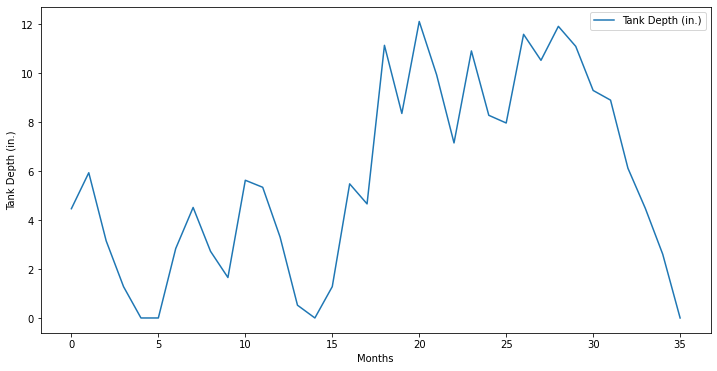

In [61]:
ax = tank_depth_df.plot(y='Tank Depth (in.)', figsize=(12,6))
ax.set_xlabel('Months')
ax.set_ylabel('Tank Depth (in.)')

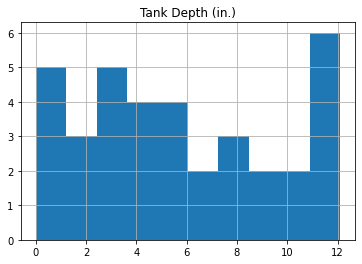

In [53]:
histogram = tank_depth_df.hist(column='Tank Depth (in.)')

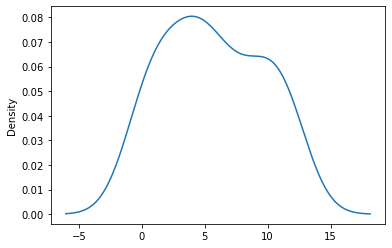

In [54]:
cdf = tank_depth_df['Tank Depth (in.)'].plot.density()

### Effects of climate change on the rancher and the farm

In 2016, the Environmental Protection Agency (EPA) published a report showing what climate change in Texas could look like. The report can be found at the link below:

https://www.epa.gov/sites/default/files/2016-09/documents/climate-change-tx.pdf

Major effects on agriculture would be increased droughts and reduced water availability. Below is a simulation that takes these effects into account. In order to account for reduced water availability, the percent captured (efficiency of the tank's water capture) parameter will be reduced. This will end up reducing the amount of water in the tank that is calculated by the tank depth function.

### Reduce percent capture from 98% to 75%

In [72]:
# return a random value from our data sample
def DirectSample():
    x = data['Rainfall'].sample()
    return x

rainfallStd = data['Rainfall'].std()
rainfall_mean = data['Rainfall'].mean()

print("sample variance = ")
print(rainfallStd)
print("sample mean = ")
print(rainfall_mean)

num_simulations = 1
num_months = 12
num_years = 30
num_months2=num_months*num_years #Uses month as the standard unit of time. January year 1 would be month 0, December year 30 would be month 360.

#Tank parameters
tank_init = 5.35 #(10000*12/7.48)/3000 starting height of water in tank in inches, converts gallons to inches, 5.35
max_height= 13.37 #(25000*12/7.48)/3000 #maximum height of water in tank; anything above this will overflow out of tank, converts gallons to inches
pct_cap=0.75 #Assume the effects of climate change reduce the availability of water. Account for this by decreasing the amount of water captured by the tank.
monthly_dis=2.78 #(5200*12/7.48)/3000 #min height of water discharged from tank per month (avg between 4000-5200 gallons [2.13-2.78 inches])

#print(f'tank init is: {tank_init}, pct cap is: {pct_cap}, monthly discharge is: {monthly_dis}')
simulation_df = pd.DataFrame()
completeSeries = []
overflow_series=[]
dry_series=[]

for x in range(num_simulations):
    count = 0
    
    rainfall_series = []
    tank_depth_series= []

    dry_count = 0
    overflow_count = 0

    for y in range(num_months2):
        if count == num_months2:
            break
        rainfall = DirectSample()
        completeSeries.append(rainfall.iloc[0])
        rainfall_series.append(rainfall)
        monthly_rainfall=rainfall.iloc[0]
        #print("Monthly Rainfall Is")
        #print(monthly_rainfall)
        if count == 0:
            #print("Tank Depth line 85")
            tank_depth=(tank_init+monthly_rainfall*pct_cap)-monthly_dis
            #print(tank_depth)
        if count >0:
                tank_depth =TankRange(tank_depth,monthly_rainfall)
                #print("Tank depth line 91")
                #print(tank_depth)

        tank_depth_series.append(tank_depth)
        count += 1
       

    simulation_df[x] = rainfall_series
    tank_depth_df=pd.DataFrame(tank_depth_series,columns=["Tank Depth (in.)"])
    overflow_series.append(overflow_count)
    dry_series.append(dry_count)

overflow_df=pd.DataFrame(overflow_series,columns=["Overflow Count"])
dry_df=pd.DataFrame(dry_series,columns=["Dry Count"])
drys=dry_df['Dry Count'].iloc[0]
overflows=overflow_df['Overflow Count'].iloc[0]
pct_dry=round((drys/num_months2)*100,0)
print(f'Across the {num_simulations} simulations, the tank ran dry {drys} times over {num_years} years and overflowed {overflows} times over {num_years} years. This equates to the tank being dry for {pct_dry}% of the year.')

import statistics

sample variance = 
2.6255197583629033
sample mean = 
2.356111111111112
Across the 1 simulations, the tank ran dry 193 times over 30 years and overflowed 1 times over 30 years. This equates to the tank being dry for 54.0% of the year.


Text(0, 0.5, 'Tank Depth (in.)')

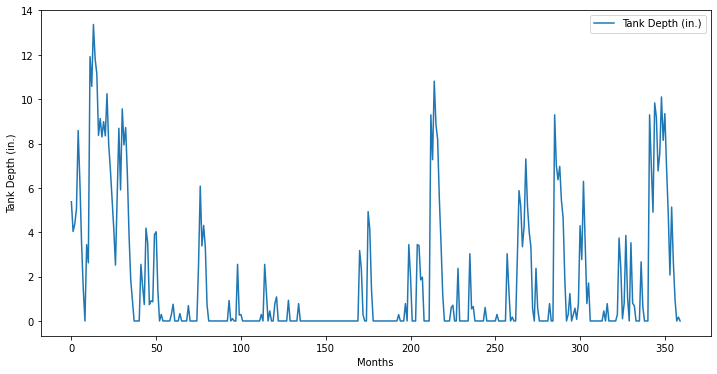

In [73]:
ax = tank_depth_df.plot(y='Tank Depth (in.)', figsize=(12,6))
ax.set_xlabel('Months')
ax.set_ylabel('Tank Depth (in.)')

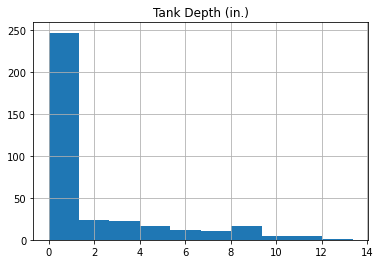

In [74]:
histogram = tank_depth_df.hist(column='Tank Depth (in.)')

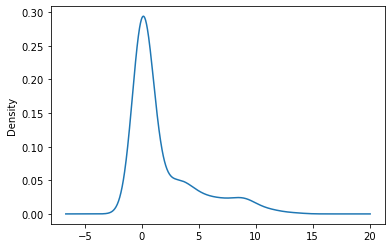

In [75]:
cdf = tank_depth_df['Tank Depth (in.)'].plot.density()

### Extremely reduced water availability due to climate change - change capture percent from 98% to 50%

In [76]:
# return a random value from our data sample
def DirectSample():
    x = data['Rainfall'].sample()
    return x

rainfallStd = data['Rainfall'].std()
rainfall_mean = data['Rainfall'].mean()

print("sample variance = ")
print(rainfallStd)
print("sample mean = ")
print(rainfall_mean)

num_simulations = 1
num_months = 12
num_years = 30
num_months2=num_months*num_years #Uses month as the standard unit of time. January year 1 would be month 0, December year 30 would be month 360.

#Tank parameters
tank_init = 5.35 #(10000*12/7.48)/3000 starting height of water in tank in inches, converts gallons to inches, 5.35
max_height= 13.37 #(25000*12/7.48)/3000 #maximum height of water in tank; anything above this will overflow out of tank, converts gallons to inches
pct_cap=0.50 #Assume the effects of climate change reduce the availability of water. Account for this by decreasing the amount of water captured by the tank.
monthly_dis=2.78 #(5200*12/7.48)/3000 #min height of water discharged from tank per month (avg between 4000-5200 gallons [2.13-2.78 inches])

#print(f'tank init is: {tank_init}, pct cap is: {pct_cap}, monthly discharge is: {monthly_dis}')
simulation_df = pd.DataFrame()
completeSeries = []
overflow_series=[]
dry_series=[]

for x in range(num_simulations):
    count = 0
    
    rainfall_series = []
    tank_depth_series= []

    dry_count = 0
    overflow_count = 0

    for y in range(num_months2):
        if count == num_months2:
            break
        rainfall = DirectSample()
        completeSeries.append(rainfall.iloc[0])
        rainfall_series.append(rainfall)
        monthly_rainfall=rainfall.iloc[0]
        #print("Monthly Rainfall Is")
        #print(monthly_rainfall)
        if count == 0:
            #print("Tank Depth line 85")
            tank_depth=(tank_init+monthly_rainfall*pct_cap)-monthly_dis
            #print(tank_depth)
        if count >0:
                tank_depth =TankRange(tank_depth,monthly_rainfall)
                #print("Tank depth line 91")
                #print(tank_depth)

        tank_depth_series.append(tank_depth)
        count += 1
       

    simulation_df[x] = rainfall_series
    tank_depth_df=pd.DataFrame(tank_depth_series,columns=["Tank Depth (in.)"])
    overflow_series.append(overflow_count)
    dry_series.append(dry_count)

overflow_df=pd.DataFrame(overflow_series,columns=["Overflow Count"])
dry_df=pd.DataFrame(dry_series,columns=["Dry Count"])
drys=dry_df['Dry Count'].iloc[0]
overflows=overflow_df['Overflow Count'].iloc[0]
pct_dry=round((drys/num_months2)*100,0)
print(f'Across the {num_simulations} simulations, the tank ran dry {drys} times over {num_years} years and overflowed {overflows} times over {num_years} years. This equates to the tank being dry for {pct_dry}% of the year.')

import statistics

sample variance = 
2.6255197583629033
sample mean = 
2.356111111111112
Across the 1 simulations, the tank ran dry 302 times over 30 years and overflowed 0 times over 30 years. This equates to the tank being dry for 84.0% of the year.


Text(0, 0.5, 'Tank Depth (in.)')

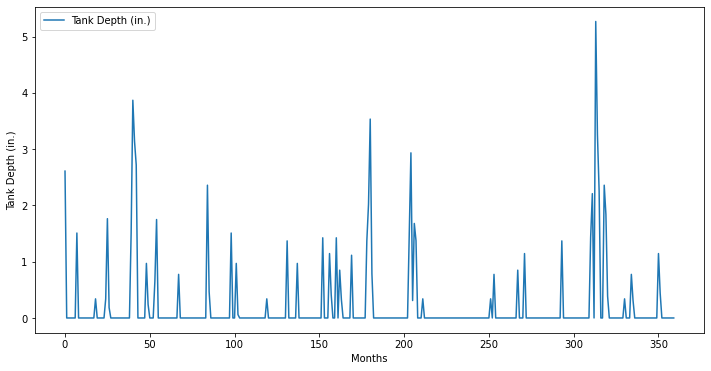

In [77]:
ax = tank_depth_df.plot(y='Tank Depth (in.)', figsize=(12,6))
ax.set_xlabel('Months')
ax.set_ylabel('Tank Depth (in.)')

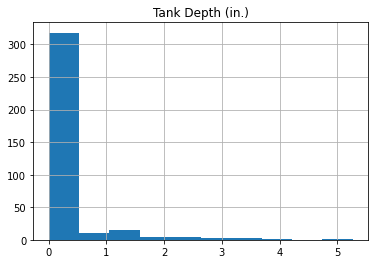

In [78]:
histogram = tank_depth_df.hist(column='Tank Depth (in.)')

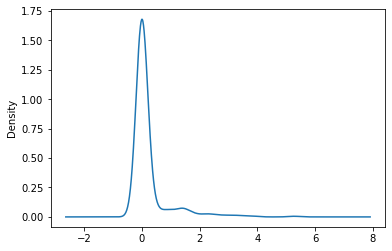

In [79]:
cdf = tank_depth_df['Tank Depth (in.)'].plot.density()

By simulating the possible effects of climate change on the rancher's agriculture, we can help inform them of what the future may look like. This information will help the rancher make decisions on how to adjust his agricultural infrastructure to be prepared for climate change. This includes using larger water tanks and employing more efficient irrigation methods that use less water.

In [80]:
#Un-used code for monthly sampling
# def SampleByMonth(month):
#     if ( month == 0 ):
#         d = data[data.variable == "Jan"]
#         return d["Rainfall"].sample()
#     if ( month == 1 ):
#         d = data[data.variable == "Feb"]
#         return d["Rainfall"].sample()
#     if ( month == 2 ):
#         d = data[data.variable == "Mar"]
#         return d["Rainfall"].sample()
#     if ( month == 3 ):
#         d = data[data.variable == "Apr"]
#         return d["Rainfall"].sample()
#     if ( month == 4 ):
#         d = data[data.variable == "May"]
#         return d["Rainfall"].sample()
#     if ( month == 5 ):
#         d = data[data.variable == "Jun"]
#         return d["Rainfall"].sample()
#     if ( month == 6 ):
#         d = data[data.variable == "Jul"]
#         return d["Rainfall"].sample()
#     if ( month == 7 ):
#         d = data[data.variable == "Aug"]
#         return d["Rainfall"].sample()
#     if ( month == 8 ):
#         d = data[data.variable == "Sep"]
#         return d["Rainfall"].sample()
#     if ( month == 9 ):
#         d = data[data.variable == "Oct"]
#         return d["Rainfall"].sample()
#     if ( month == 10 ):
#         d = data[data.variable == "Nov"]
#         return d["Rainfall"].sample()
#     if ( month == 11 ):
#         d = data[data.variable == "Dec"]
# #         return d["Rainfall"].sample()

#     return 2.356    